#TODO
method prop支持classification
q oracle功能未实现

In [1]:
from sklearn.model_selection import StratifiedKFold,cross_val_predict
from sklearn.neighbors import KernelDensity
import numpy as np
import pandas as pd
import copy

from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

In [86]:
data=pd.read_csv("D:\Rworkspace\LDML\data.csv",index_col=0)
data.index=data.index-1
cv=pd.read_csv("D:\Rworkspace\LDML\cvgroup.csv",index_col=0)
cv.index=cv.index-1

cvgroup=[]
for i in range(1,6):
    train=cv[cv!=i].dropna().index.values
    test=cv[cv==i].dropna().index.values
    print('train -  {}   |   test -  {}'.format(np.bincount(data[form_t][train]), np.bincount(data[form_t][test])))
    cvgroup.append((train,test))

gammas=[0.25,0.5,0.75]
form_x=["age","inc","educ","fsize","marr","twoearn","db","pira","hown" ]
form_t="p401"
form_y="net_tfa"

z=0# test pointer

NameError: name 'form_t' is not defined

In [ ]:
def cross_fit_propensities(data, cvgroup, form_x, form_t, method_prop, trim=(0.01,0.99), trim_type='none', normalize=True):
    '''cross_val train and predict prop score, then process them'''
    #prop=np.zeros(data.shape[0]) 
    #for train_idx,test_idx in cvgroup:
    #    fitted_model=method_prop.fit(data.loc[train_idx][form_x],data.loc[train_idx][form_t])
    #    prop[test_idx] = fitted_model.predict(data.loc[test_idx][form_x])

    #t为自变量，x为因变量，进行kfold训练和预测
    #cv:An iterable that generates (train, test) splits as arrays of indices.
    prop=cross_val_predict(method_prop, data[form_x], data[form_t], cv=cvgroup)
    
    if trim_type == 'drop':
        keep = np.logical_and(prop>trim[0],prop<trim[1])
        prop[~keep] = 0.5
    else:
        keep = np.full(data.shape[0],True) #otherwise,keep all rows  
        
    if trim_type == 'clip':
        prop=np.clip(prop,trim[0],trim[1])

    #we normalize propensity weights to have mean 1 within each treatment group
    #(In each group) P_i=P_i*MEAN(1/P_i),therefore 1/P_i would have mean 1
    if normalize:
        prop[keep] = data[form_t][keep]*prop[keep]*np.mean(data[form_t][keep]/prop[keep]) + \
                    (1.-data[form_t][keep])*(1.-(1.-prop[keep])*np.mean((1.-data[form_t][keep])/(1.-prop[keep])))
    
    return prop,keep

#测试
if True:
    method_prop=RandomForestRegressor(n_estimators=100, max_depth=7, max_features=3, min_samples_leaf=3)
    result=cross_fit_propensities(data, cvgroup,form_x ,form_t ,method_prop, trim=(0.01,0.99), trim_type='none', normalize=True)

In [ ]:
np.mean(result[0])

0.26052574978456966

In [ ]:
def solve_cumsum(vector,c):
    '''Return i for i such that summing vector[1:i] is closest to c'''
    return pd.Series(abs(np.cumsum(vector)-c)).idxmin()#keep index info
#测试
solve_cumsum(pd.Series([1,2,3,4],index=[-3,-2,1,2]),2.1)

-2

In [ ]:
def density(X, w, x):
    '''Estimate the density of data in X at point(s) x with weights w'''
    X=np.array(X)
    if X.ndim==1:
        X=X.reshape(-1,1)
    x=np.array([x]).reshape(-1,1)
    kde = KernelDensity(kernel='gaussian', bandwidth="scott").fit(X=X,sample_weight=w)#fit whole curve
    return np.exp(kde.score_samples(x))#predict points
#测试
density(np.array([1,2,3,4,5]),np.ones(5),np.array([1,2,3,4,5]))

array([0.15504953, 0.19754675, 0.19997058, 0.19754675, 0.15504953])

In [ ]:
def est_quantile_ipw(gammas, data, form_x, form_t, form_y, method_prop, \
                    K=5, trim=(0.01,0.99), trim_type='none', normalize=True, avg_eqn=True):
    """
    gammas:list
        quantiles to be estimated
    data:dataframe 
        dataset
    form_x:list of string
        specify columns for x
    form_t,form_y:string
        specify columns for t,y respectively (only support single treatment variable, so far)
    method_prop:estimator implementing ``fit()`` and ``predict()``
        method and option for propsperity score estimation, if treatment variable is binary, 
        then a classification model is acceptable
    K:int
        kfold_num
    trim:list or tuple
        upper and lower bound for trim_type=='clip'
    trim_type:str
        method use to deal with points which has extreme prop score,'drop' or 'clip' or 'none'
    normalize:bool
        whether to normalize prop score in each treatment group
    avg_eqn:bool
        if True, estimate q on whole data;
        else, estimate q in each fold, then take their mean as final estimation
    """
    #prepare for solve_cumsum 
    data.sort_values(by=form_y,ascending=True,inplace=True)
    data.reset_index(drop=True,inplace=True)

    #分层cv
    skf = StratifiedKFold(n_splits=K,shuffle=True)
    cvgroup=[]
    for train, test in skf.split(data, data[form_t]):
        cvgroup.append((train,test))#train,test are list, see demo1
    
    prop,keep = cross_fit_propensities(data, cvgroup, form_x, form_t, method_prop,\
                                    trim=trim, trim_type=trim_type, normalize=normalize)

    w1=keep*data[form_t]/prop
    w0=keep*(1-data[form_t])/(1-prop)

    result=[]
    for i,gamma in enumerate(gammas):
        if avg_eqn:    
            q1=data[form_y][solve_cumsum(w1/sum(keep),gamma)]
            q0=data[form_y][solve_cumsum(w0/sum(keep),gamma)]
        else:
            q1_list=[]
            q0_list=[]
            for train,test in cvgroup:
                # solve_cumsum keeps origin index, so data[form_y] doesn't need to slice
                q1_list.append(data[form_y][solve_cumsum(w1[test]/sum(keep[test]),gamma)])
                q0_list.append(data[form_y][solve_cumsum(w0[test]/sum(keep[test]),gamma)])
            q1=np.mean(q1_list)
            q0=np.mean(q0_list)
        
        # sample value of score function/J, J is estimated by IPW kde at q
        keep_t1_mask=np.logical_and(data[form_t]==1,keep)
        keep_t0_mask=np.logical_and(data[form_t]==0,keep)
        # density result is different from R, more accurated
        psi1=(w1[keep]*(data[form_y][keep]<=q1)-gamma)/density(data[form_y][keep_t1_mask], 1/prop[keep_t1_mask], q1)
        psi0=(w0[keep]*(data[form_y][keep]<=q0)-gamma)/density(data[form_y][keep_t0_mask], 1/(1-prop[keep_t0_mask]), q0)#???

        se1 = np.std(psi1,ddof=1) / np.sqrt(sum(keep))
        se0 = np.std(psi0,ddof=1) / np.sqrt(sum(keep))
        seqte = np.std(psi1-psi0,ddof=1) / np.sqrt(sum(keep))

        result.append(pd.DataFrame({'gamma':gamma,'q1':q1,'q0':q0,'qte':q1-q0,\
                                    'se1':se1,'se0':se0,'seqte':seqte},index=[i]))
    
    return pd.concat(result,axis=0)
    
method_prop = linear_model.Lasso(alpha=0.5)
result=est_quantile_ipw(gammas, data, form_x, form_t, form_y, method_prop, \
                    K=5, trim=(0.01,0.99), trim_type='clip', normalize=True, avg_eqn=True)
result

,gamma,q1,q0,qte,se1,se0,seqte
0,0.25,1402.0,-900.0,2302.0,10.682257,1.013900,10.837746
1,0.50,9649.0,700.0,8949.0,13.788891,1.328567,14.201045
2,0.75,34200.0,13139.0,21061.0,50.884474,38.668499,72.025490


![](ldml.png)

In [ ]:
def est_quantile_ldml(gammas, data, form_x, form_t, form_y, method_ipw,method_prop, method_cdf,\
                     K=5, K_ipw=0, semiadaptive=False, trim=(0.01,0.99), trim_type='none',\
                     normalize=True, avg_eqn=True):
    """
    gammas:list
        quantiles to be estimated
    data:dataframe 
        dataset
    form_x:list of string
        specify columns for x
    form_t,form_y:string
        specify columns for t,y respectively (only support single treatment variable, so far)
    method_prop:estimator implementing ``fit()`` and ``predict()``
        method and option for propsperity score estimation, if treatment variable is binary, 
        then a classification model is acceptable
    method_ipw,method_cdf:
        same as method_prop
    K:int
        kfold_num
    K_ipw:int
        folds use to estimate fixed value for localization
        default value: np.ceil((K-1)/2)
    semiadaptive:bool
        if semiadaptive is set to TRUE then we use all out-of-fold data for both IPW and fitting nuisances,
        otherwise, out-of-fold data would be spilt into 2 parts for IPW and nuis1 estimation respectively
    trim:list or tuple
        upper and lower bound for trim_type=='clip'
    trim_type:str
        method use to deal with points which has extreme prop score,'drop' or 'clip' or 'none'
    normalize:bool
        whether to normalize prop score in each treatment group
    avg_eqn:
        if True, estimate q on whole data;
        else, estimate q in each fold, then take their mean as final estimation
    """
    #prepare for solve_cumsum 
    data.sort_values(by=form_y,ascending=True,inplace=True)
    data.reset_index(drop=True,inplace=True)
    
    skf = StratifiedKFold(n_splits=K)
    cvgroup=[]
    split_cvgroup=[]
    for train, test in skf.split(data, data[form_t]):
        cvgroup.append((train,test))#train,test are list, see demo1
        if not semiadaptive:
            l=len(train)
            ipw_train=train[:l//2]
            nuis1_train=train[l//2:]
            split_cvgroup.append((ipw_train,nuis1_train,test))
        else:
            split_cvgroup.append((copy.deepcopy(train),copy.deepcopy(train),test))#need copy???

    #nuis2
    prop,keep = cross_fit_propensities(data, cvgroup, form_x, form_t, method_prop,\
                                    trim=trim, trim_type=trim_type, normalize=normalize)
    w1=keep*data[form_t]/prop
    w0=keep*(1-data[form_t])/(1-prop)

    if K_ipw==0:
        K_ipw=int(np.ceil((K-1)/2))#向上取整
    
    result=[]
    for i,gamma in enumerate(gammas):
        cdf0,cdf1=np.zeros(data.shape[0]),np.zeros(data.shape[0])

        for ipw_train,nuis1_train,test in split_cvgroup:
            #use take method instead of iloc, for automatiaclly copy
            ipw_result = est_quantile_ipw([gamma], data.take(ipw_train), form_x, form_t, form_y, method_ipw, \
                        K=K_ipw, trim=(0.01,0.99), trim_type='clip', normalize=True, avg_eqn=True)

            def fit_predict(cdf,q):   
                cdf_goal=(data[form_y]<=ipw_result[q][0])
                cdf_fit=method_cdf.fit(data.take(nuis1_train),cdf_goal.take(nuis1_train))
                cdf[test]=cdf_fit.predict(data.take(test))

            fit_predict(cdf1,'q1')
            fit_predict(cdf0,'q0')

        def ldml_formula(w,cdf,q_num,mask):
            if q_num==1:
                p=(1.- data[form_t][mask]/prop[mask])
            elif q_num==0:
                p=(1.-data[form_t][mask])/(1.-prop[mask])

            return data[form_y][solve_cumsum(w[mask]/sum(mask),gamma - np.mean(cdf[mask]*p))]
            
        if avg_eqn:
            q1=ldml_formula(w1,cdf1,1,keep)
            q0=ldml_formula(w0,cdf0,1,keep)
        else:
            q1_list,q0_list=[],[]
            for ipw_train,nuis1_train,test in split_cvgroup:
                q1=ldml_formula(1,keep&test)
                q0=ldml_formula(0,keep&test)
            q1,q0=np.mean(q1_list),np.mean(q0_list)
        
        def score_func(w,q,cdf,q_num,mask):
            if q_num==1:
                p=(1.- data[form_t][mask]/prop[mask])
            elif q_num==0:
                p=(1.-data[form_t][mask])/(1.-prop[mask])        
            return (w[keep] * (data[form_y][keep] <= q)-gamma-cdf[mask]*p)

        # sample value of score function/J, J is estimated by IPW kde at q
        keep_t1_mask=np.logical_and(data[form_t]==1,keep)
        keep_t0_mask=np.logical_and(data[form_t]==0,keep)
        psi1=score_func(w1,q1,cdf1,1,keep)/density(data[form_y][keep_t1_mask], 1/prop[keep_t1_mask], q1)
        psi0=score_func(w0,q0,cdf0,0,keep)/density(data[form_y][keep_t0_mask], 1/(1-prop[keep_t0_mask]), q0)

        se1 = np.std(psi1,ddof=1) / np.sqrt(sum(keep))
        se0 = np.std(psi0,ddof=1) / np.sqrt(sum(keep))
        seqte = np.std(psi1-psi0,ddof=1) / np.sqrt(sum(keep))
        result.append(pd.DataFrame({'gamma':gamma,'q1':q1,'q0':q0,'qte':q1-q0,\
                                    'se1':se1,'se0':se0,'seqte':seqte},index=[i]))
    return pd.concat(result,axis=0)

method_prop = RandomForestRegressor(n_estimators=50, max_depth=7, max_features=3, min_samples_leaf=3)
result=est_quantile_ldml(gammas, data, form_x, form_t, form_y, method_prop,method_prop,method_prop, \
                    K=5, trim=(0.01,0.99), trim_type='clip', normalize=True, avg_eqn=True)
result

,gamma,q1,q0,qte,se1,se0,seqte
0,0.25,280.0,-775.0,1055.0,4.265764,6.481763,8.015013
1,0.50,5552.0,999.0,4553.0,36.589348,1.570385,36.916521
2,0.75,22870.0,15350.0,7520.0,64.956145,15.464816,72.081517


In [ ]:
#demo1
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
X, y = np.ones((50, 1)), np.hstack(([0] * 45, [1] * 5))
skf = StratifiedKFold(n_splits=3)
for train, test in skf.split(X, y):
    print(train,test)
    print('train -  {}   |   test -  {}'.format(np.bincount(y[train]), np.bincount(y[test])))

kf = KFold(n_splits=3)
for train, test in kf.split(X, y):
    print('train -  {}   |   test -  {}'.format(np.bincount(y[train]), np.bincount(y[test])))

[15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38
 39 40 41 42 43 44 47 48 49] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 45 46]
train -  [30  3]   |   test -  [15  2]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 30 31 32 33 34 35 36 37 38
 39 40 41 42 43 44 45 46 49] [15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 47 48]
train -  [30  3]   |   test -  [15  2]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 45 46 47 48] [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 49]
train -  [30  4]   |   test -  [15  1]
train -  [28  5]   |   test -  [17]
train -  [28  5]   |   test -  [17]
train -  [34]   |   test -  [11  5]


In [ ]:
#demo-classification
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
X, y = load_iris(return_X_y=True)
clf = LogisticRegression(penalty='l1',solver='liblinear',random_state=0).fit(X, y)
print(clf.predict(X[:2, :]))
clf.predict_proba(X[:2, :])

[0 0]


array([[8.85204244e-01, 1.14795704e-01, 5.16221340e-08],
       [7.93563244e-01, 2.06436477e-01, 2.79376439e-07]])

In [2]:
#demo-regressor
from sklearn.ensemble import RandomForestRegressor
randomForest = RandomForestRegressor(
    n_estimators=50, max_depth=7, max_features=3, min_samples_leaf=3)
model=randomForest.fit(X,y)
print(model.predict(X))

NameError: name 'X' is not defined

In [ ]:
#data generate (Y missing)
import numpy as np
import pandas as pd
def test_data_generator(n=1000,miss_ratio=0.2):
    n_miss=int(n*miss_ratio)
    n_obs=n-n_miss
    x1=np.random.normal(1, 1, n)
    x2=np.random.normal(1, 1, n)
    x3=np.random.normal(2, 1, n)
    y=2*x1+0.5*x2+3*x3+np.random.normal(0, 1, n)
    mask=np.append(np.ones(n_obs),np.zeros(n_miss))
    np.random.shuffle(mask)
    y=np.where(mask==1,y,np.nan)
    return pd.DataFrame({'X1':x1,'X2':x2,'X3':x3,'Y':y,'R':mask},index=np.arange(n))

data=test_data_generator(n=1000)

In [ ]:
data

,X1,X2,X3,Y,R
0,1.043606,0.071573,2.261580,10.024640,1.0
1,1.710542,-0.324372,1.909698,7.699883,1.0
2,1.777750,1.878143,0.341764,4.540206,1.0
3,0.381029,0.793881,1.751978,5.309508,1.0
4,1.167231,1.551184,1.384395,8.831004,1.0
5,2.783786,0.539434,4.557051,19.407859,1.0
6,0.493483,1.430536,2.962223,NaN,0.0
7,1.849812,-0.272040,1.661641,9.945182,1.0
8,1.991920,-0.292253,1.962195,NaN,0.0
9,0.907190,0.448751,4.120888,15.674636,1.0


In [ ]:
#implementation of DML
from numpy.linalg import inv

p=0
def prepare_data(data):
    #我们应当手动插入R变量，符合用户需求
    #insert column R
    pass

def dml(data,form_x,form_y,model,K=5):
    skf = StratifiedKFold(n_splits=K,shuffle=True)
    cvgroup=[]
    for train, test in skf.split(data, data['R']):
        cvgroup.append((train,test))
    
    lambda_dic={}
    mu_dic={}
    psi_a=pd.DataFrame(0,index=form_x,columns=form_x)
    psi_b=pd.Series(0,index=form_x)
    for i,(train,test) in enumerate(cvgroup):
        X=data.take(test)[form_x]
        Y=data.take(test)[form_y].fillna(0).values
        R=data.take(test)['R'].values

        #lambda=P(R=1|X)
        lambda_=data.take(train)['R'].mean()
        lambda_dic[str(i)]=lambda_#scalar

        #mu=E(Y|X,R=1)
        train_set=data.take(train).dropna()
        mu_model=model.fit(train_set[form_x],train_set[form_y].values)
        mu=mu_model.predict(X)
        mu_dic[str(i)]=mu#vector

        #psi_a=XX^T (the notion for X is reverse, i.e. X in python is X^T in paper)
        #psi_b=X[R(Y-mu)/lambda+mu]
        psi_a+=(X.T).dot(X)/len(test)
        psi_b+=X.T.dot(R*(Y-mu)/lambda_+mu)/len(test)

    coef=inv(psi_a).dot(psi_b)#main para to be estimated
    print(coef)

    J0=psi_a/K
    PSI2=pd.DataFrame(0,index=form_x,columns=form_x)
    for i,(train,test) in enumerate(cvgroup):
        X=data.take(test)[form_x]
        Y=data.take(test)[form_y].fillna(0).values
        R=data.take(test)['R'].values

        lambda_=lambda_dic[str(i)]
        mu=mu_dic[str(i)]
        
        #notice the 'mul' here, not dot
        #right part is vector of shape (n_sample,)
        #left part is matrix of shape(form_x, n_sample)
        psi=X.T.mul(R*(Y-mu)/lambda_+mu-X.dot(coef))
        PSI2=PSI2+psi.dot(psi.T)/len(test)

    PSI2=PSI2/K
    sigma2=inv(J0).dot(PSI2).dot(inv(J0))/data.shape[0]
  
    return (coef,np.diagonal(np.sqrt(sigma2)),sigma2)
    
dml(data,['X1','X2','X3'],'Y',lm)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
def test_data_generator(n=1000,miss_ratio=0.2):
    n_miss=int(n*miss_ratio)
    n_obs=n-n_miss
    x1=np.random.normal(1, 1, n)
    x2=np.random.normal(1, 1, n)
    x3=np.random.normal(2, 1, n)
    y=2*x1+0.5*x2+3*x3+np.random.normal(0, 1, n)
    mask=np.append(np.ones(n_obs),np.zeros(n_miss))
    np.random.shuffle(mask)
    x1=np.where(mask==1,x1,np.nan)
    return pd.DataFrame({'X1':x1,'X2':x2,'X3':x3,'Y':y,'R':mask},index=np.arange(n))

data=test_data_generator(n=1000)

In [ ]:
#linear missing X continuous

p=0
def dml(data,form_x,form_z,form_y,model,K=5):
    '''
    form_x, form_y is str scalar
    support one missing variable so far
    '''
    form_yz=form_z+[form_y]

    K=5
    skf = StratifiedKFold(n_splits=K,shuffle=True)
    cvgroup=[]
    for train, test in skf.split(data, data['R']):
        cvgroup.append((train,test))
    
    lambda_dic={}
    mu1_dic={}
    mu2_dic={}
    psi_a=pd.DataFrame(0,index=[form_x]+form_z,columns=[form_x]+form_z)
    psi_b=pd.Series(0,index=[form_x]+form_z)
  
    for i,(train,test) in enumerate(cvgroup):
        X=data.take(test)[form_x].fillna(0).values
        Y=data.take(test)[form_y].values
        Z=data.take(test)[form_z]
        R=data.take(test)['R'].values

        #lambda=P(R=1|Z,Y)
        lambda_=data.take(train)['R'].mean()
        lambda_dic[str(i)]=lambda_#scalar

        #mu1=E(X|Z,Y,R=1)
        #mu2=E(XX^T|Z,Y,R=1)
        train_set=data.take(train).dropna()
        mu1_model=model.fit(train_set[form_yz],train_set[form_x].values)
        mu1=mu1_model.predict(data.take(test)[form_yz])
        mu2_model=model.fit(train_set[form_yz],np.power(train_set[form_x].values,2))#new fit would override old fit
        mu2=mu2_model.predict(data.take(test)[form_yz])
        mu1_dic[str(i)]=mu1#vector
        mu2_dic[str(i)]=mu2#vector

        left_up=pd.DataFrame(sum(R*(np.power(X,2)-mu2)/lambda_+mu2),index=[form_x],columns=[form_x])
        left_down=pd.DataFrame(Z.T.dot(R*(X-mu1)/lambda_+mu1),columns=[form_x])
        psi_a=psi_a+pd.concat([pd.concat([left_up,left_down.T],axis=1),\
                            pd.concat([left_down,Z.T.dot(Z)],axis=1)],axis=0)/len(test)
    
        psi_b=psi_b+pd.concat([pd.Series(sum(Y*(R*(X-mu1)/lambda_+mu1)),index=[form_x]),Z.T.dot(Y)],axis=0)/len(test)
  
    coef=inv(psi_a).dot(psi_b)#main para to be estimated
    coef=pd.DataFrame(coef,index=[form_x]+form_z)
    #return coef
    beta=coef.loc[form_x][0]
    gamma=coef.loc[form_z][0].values

    J0=psi_a/K
    PSI2=pd.DataFrame(0,index=[form_x]+form_z,columns=[form_x]+form_z)

    for i,(train,test) in enumerate(cvgroup):
        X=data.take(test)[form_x].fillna(0).values
        Y=data.take(test)[form_y].values
        Z=data.take(test)[form_z]
        R=data.take(test)['R'].values

        lambda_=lambda_dic[str(i)]
        mu1=mu1_dic[str(i)]
        mu2=mu2_dic[str(i)]

        up=(R*(X-mu1)/lambda_+mu1)*(Y-Z.dot(gamma))-(R*(np.power(X,2)-mu2)/lambda_+mu2)*beta
        down=Z.T.mul(Y-(R*(X-mu1)/lambda_+mu1)*beta-Z.dot(gamma))
        up=pd.DataFrame(up,columns=[form_x]).T

        psi=pd.concat([up,down],axis=0)
        PSI2=PSI2+psi.dot(psi.T)/len(test)

    PSI2=PSI2/K
    sigma2=inv(J0).dot(PSI2).dot(inv(J0))/data.shape[0]
  
    return (coef,np.diagonal(np.sqrt(sigma2)),sigma2)

dml(data,'X1',['X2','X3'],'Y',randomForest)

0 (3, 200) (3, 3)
1 (3, 200) (3, 3)
2 (3, 200) (3, 3)
3 (3, 200) (3, 3)
4 (3, 200) (3, 3)


C:\Users\11861\AppData\Local\Temp\ipykernel_11168\788730065.py:81: RuntimeWarning: invalid value encountered in sqrt
  return (coef,np.diagonal(np.sqrt(sigma2)),sigma2)


(           0
 X1  2.039944
 X2  0.467044
 X3  2.984812,
 array([0.03547157, 0.03457739, 0.02377895]),
 array([[ 0.00125823, -0.00030592, -0.00035328],
        [-0.00030592,  0.0011956 , -0.00039493],
        [-0.00035328, -0.00039493,  0.00056544]]))

In [22]:
#data generate (Y missing)
import numpy as np
import pandas as pd
def test_data_generator(n=1000,miss_ratio=0.2):
    n_miss=int(n*miss_ratio)
    n_obs=n-n_miss
    x1=np.random.normal(1, 1, n)
    x2=np.random.normal(1, 1, n)
    x3=np.random.normal(2, 1, n)
    p=1/(1+np.exp(-(2*x1+0.5*x2+3*x3+np.random.normal(0, 0.5, n))))
    y=np.random.binomial(1,p)
    mask=np.append(np.ones(n_obs),np.zeros(n_miss))
    np.random.shuffle(mask)
    y=np.where(mask==1,y,np.nan)
    return pd.DataFrame({'X1':x1,'X2':x2,'X3':x3,'Y':y,'R':mask},index=np.arange(n))

data=test_data_generator(n=1000)

In [23]:
#logistic missing Y
from scipy.optimize import fsolve

def dml(data,form_x,form_y,model,K=5):
    #support to use classification method
    skf = StratifiedKFold(n_splits=K,shuffle=True)
    cvgroup=[]
    for train, test in skf.split(data, data['R']):
        cvgroup.append((train,test))
    
    def score_function(coef):
        result=np.zeros(len(form_x))
        for i,(train,test) in enumerate(cvgroup):
            X=data.take(test)[form_x]
            Y=data.take(test)[form_y].fillna(0).values
            R=data.take(test)['R'].values

            #lambda=P(R=1|X)
            lambda_=data.take(train)['R'].mean()

            #mu=E(Y|X,R=1)
            train_set=data.take(train).dropna()
            mu_model=model.fit(train_set[form_x],train_set[form_y].values)
            mu=mu_model.predict_proba(X)[:,1]#prob of group 1, each row is a 2 element vector
            result=result+X.T.dot(R*(Y-mu)/lambda_+mu-1/(1+np.exp(-X.dot(coef))))
        return result

    result=fsolve(score_function,np.ones(len(form_x)))
    return result

model=LogisticRegression(C=1000)
dml(data,['X1','X2','X3'],'Y',model)

array([1.81601089, 0.33196636, 3.21246467])

In [4]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()

In [39]:
def test_data_generator(n=1000,miss_ratio=0.2):
    n_miss=int(n*miss_ratio)
    n_obs=n-n_miss
    x1=np.random.normal(1, 1, n)
    x2=np.random.normal(1, 1, n)
    x3=np.random.normal(2, 1, n)
    p=1/(1+np.exp(-(2*x1+0.5*x2+3*x3+np.random.normal(0, 0.5, n))))
    #p=1/(1+np.exp(-(1*x1+1*x2+1*x3+np.random.normal(0, 1, n))))
    y=np.random.binomial(1,p)
    mask=np.append(np.ones(n_obs),np.zeros(n_miss))
    np.random.shuffle(mask)
    x1=np.where(mask==1,x1,np.nan)
    return pd.DataFrame({'X1':x1,'X2':x2,'X3':x3,'Y':y,'R':mask},index=np.arange(n))

data=test_data_generator(3000,0.8)
data

,X1,X2,X3,Y,R
0,NaN,0.517342,2.248985,1,0.0
1,NaN,1.007426,1.590435,1,0.0
2,NaN,1.600636,2.032802,1,0.0
3,NaN,1.539362,1.526738,1,0.0
4,NaN,0.846247,1.643792,1,0.0
...,...,...,...,...,...
2995,NaN,2.660026,1.408812,1,0.0
2996,1.568928,1.098373,2.720613,1,1.0
2997,NaN,0.104843,5.149944,1,0.0
2998,NaN,0.697529,2.838838,1,0.0


In [41]:
p=0
from scipy.optimize import fsolve
from drf import drf
def ldml(data,form_x,form_z,form_y,model_ipw,model_mu1,K=5):    
    form_yz=form_z+[form_y]

    K=5
    skf = StratifiedKFold(n_splits=K,shuffle=True)
    cvgroup=[]
    for train, test in skf.split(data, data['R']):
        cvgroup.append((train,test))
    
    lambda_dic={}
    eta_dic={}

    for i,(train,test) in enumerate(cvgroup):
        l=len(train)
        ipw_train=train[:l//2]#dat1
        nuis1_train=train[l//2:]#dat2
        #nuis2_train=train
        
        lambda_=data.take(train)['R'].mean()
        
        train_set=data.take(train).dropna()
        ipw_train_set=data.take(ipw_train).dropna()
        nuis1_train_set=data.take(nuis1_train).dropna()
        
        #model_ipw must be GLM model, have coef_
        model_ipw.fit(ipw_train_set[[form_x]+form_z],ipw_train_set[form_y])
        theta_ipw=model_ipw.coef_[0]
        theta_ipw_intercept=model_ipw.intercept_

        #regression model, fxxk
        model_mu1.fit(train_set[form_yz],train_set[form_x])
        mu1=model_mu1.predict(data.take(test)[form_yz])

        DRF = drf(min_node_size = 15, num_trees = 2000, splitting_rule = "FourierMMD") #those are the default values
        DRF.fit(nuis1_train_set[form_yz],nuis1_train_set[form_x])
        mu=DRF.predict(newdata = data.take(test)[form_yz]).weights
        
        #index:test set; columns:nuis1 train set 
        part1=data.take(test)[form_z].dot(theta_ipw[1:])+theta_ipw_intercept#constant item
        part1=pd.concat([part1]*mu.shape[1],axis=1)
        part1.columns=nuis1_train_set.index
        part2=theta_ipw[0]*nuis1_train_set[form_x]
        part2=pd.concat([part2]*mu.shape[0],axis=1).T
        part2.index=test
        
        expX=1/(1+np.exp(-part1-part2))
        X_matrix=pd.concat([nuis1_train_set[form_x]]*mu.shape[0],axis=1).T
        X_matrix.index=test
        XexpX=X_matrix*expX
        mu2=(expX*mu).sum(axis=1)
        mu3=(XexpX*mu).sum(axis=1)
        Y=data.take(test)[form_y].values
        Z=data.take(test)[form_z]
        eta=pd.concat([mu1*Y-mu3,Z.apply(lambda x:x*(Y-mu2))],axis=1).T
        eta.index=[form_x]+form_z
        lambda_dic[str(i)]=lambda_
        eta_dic[str(i)]=eta

    def score_function(coef):
        result=np.zeros(len([form_x]+form_z))
        for i,(train,test) in enumerate(cvgroup):
            XZ=data.take(test)[[form_x]+form_z].fillna(0)
            Y=data.take(test)[form_y].values
            R=data.take(test)['R'].values
            result=result+XZ.T.dot(R/lambda_dic[str(i)]*(Y-1/(1+np.exp(-XZ.dot(coef)))))\
                    -eta_dic[str(i)].dot(R/lambda_dic[str(i)]-1)
        return result

    result=fsolve(score_function,np.zeros(len([form_x]+form_z)))
    return result

rr=np.zeros(3)
for i in range(3):
    print(i)
    r=ldml(data,'X1',['X2','X3'],'Y',model,randomForest)
    print(r)
    rr+=r
rr/3

0
[2.96015007 0.54438624 3.14001948]
1
[1.58775421 0.67915339 2.49721628]
2
[2.25999764 0.54816058 2.76612532]


array([2.26930064, 0.59056673, 2.80112036])

In [ ]:
p[0]-p[1].dot(p[2])

X1      NaN
X2      NaN
X3      NaN
(X1,)   NaN
(X2,)   NaN
(X3,)   NaN
dtype: float64

In [ ]:
import pandas as pd
import numpy as np
from drf import drf

# generate data
n = 1000
p = 10
d = 1
X = np.random.normal(0, 1, size=(n, p))
Y = np.random.normal(0, 1, size=(n, d))
Y[:,0] = Y[:,0] + X[:,0] #mean shift of Y1 based on X1
#Y[:,1] = Y[:,1] * X[:,1] #variance shift of Y2 based on X2
X = pd.DataFrame(X)
Y = pd.DataFrame(Y)

# fit model
DRF = drf(min_node_size = 15, num_trees = 2000, splitting_rule = "FourierMMD") #those are the default values
DRF.fit(X, Y)
DRF.info() #prints variable importance

#generate test data
X_test = pd.DataFrame(np.random.normal(0, 1, size=(100, p)))

# estimated conditional distribution represented via weights
out = DRF.predict(newdata = X_test)
print(out.weights)

# many distributional functionals are implemented and do not need to be manually computed from the weights
#out = DRF.predict(newdata = X_test, functional = "mean")
#print(out.mean)

# covariance matrix at a fixed test point
#out = DRF.predict(newdata = [0]*p, functional = "cov")
#print(out.cov[0,:,:])

# we can transform the response beforehand to obtain more complicated quantities
#out = DRF.predict(newdata = X_test, functional = "quantile", transformation = lambda y: (np.sin(y[1]), y[1]*y[2], y[2]**2), quantiles=[0.1, 0.9])
#print(out.quantile[0,1,:]) # 0.1 and 0.9 quantiles for first test point in newdata and for the second component of transformed y

# we automatically handle factor variables by using one-hot encoding
#X['cat'] = np.random.choice(['a', 'b', 'c', 'd', 'e'], n, replace=True)
#Y['new'] = np.random.normal(0, 1, size=n) + (X['cat']=='a')
#DRF.fit(X, Y)
#DRF.info()

DRF forest object
Number of trees: 2000 
Number of training samples: 1000 
[[0.00000000e+00 0.00000000e+00 2.94393581e-03 ... 4.26027189e-04
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.14254130e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.27865122e-03 1.31578947e-05 0.00000000e+00 ... 3.57142857e-05
  1.81336824e-03 3.32688338e-04]
 ...
 [0.00000000e+00 0.00000000e+00 4.94653964e-03 ... 1.19047619e-04
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.29815658e-03 ... 7.20238095e-05
  0.00000000e+00 0.00000000e+00]
 [5.51677693e-04 0.00000000e+00 9.33395018e-04 ... 7.72840385e-03
  0.00000000e+00 0.00000000e+00]]


In [ ]:
X

,0,1,2,3,4,5,6,7,8,9
0,-0.839279,0.834735,0.974269,0.836350,0.368807,-0.793491,-2.755367,-0.560605,0.587878,-0.637156
1,-2.121507,1.300074,-0.561701,-2.296089,-0.017208,0.432750,0.106960,-0.572037,-0.696893,-1.541959
2,-0.427485,0.978987,-1.724091,0.846568,0.047978,0.454522,0.372446,0.845299,1.855142,1.138090
3,-0.326549,0.056731,-0.153277,-0.236694,0.936951,-1.035882,2.439180,-1.065583,0.190394,0.395279
4,-0.819528,0.100236,0.159197,-0.182262,-0.853618,-1.247837,2.258070,1.497072,-0.513532,-0.511317
...,...,...,...,...,...,...,...,...,...,...
995,-0.069951,0.649928,0.424573,-0.478366,1.015995,1.787796,-0.105664,-0.633291,-0.220389,-0.714845
996,-0.164187,-0.311909,0.658577,-1.353395,-0.961323,-0.489341,-0.078234,1.324460,0.927713,-1.695038
997,-1.346707,0.911846,0.658291,1.349356,-1.892918,1.867004,-1.378368,-1.011910,-0.216135,0.086206
998,1.004626,-0.207452,0.587687,-0.362467,0.772684,0.049112,0.318914,-1.272253,0.278229,0.372447


In [ ]:
Y

,0,1
0,-0.367141,-0.401015
1,-0.938872,-0.144053
2,-3.216640,0.522024
3,-2.165030,0.038185
4,-1.114243,0.049238
...,...,...
995,-0.632295,1.250565
996,0.685566,-0.328939
997,-1.344502,0.185293
998,2.236488,0.001301


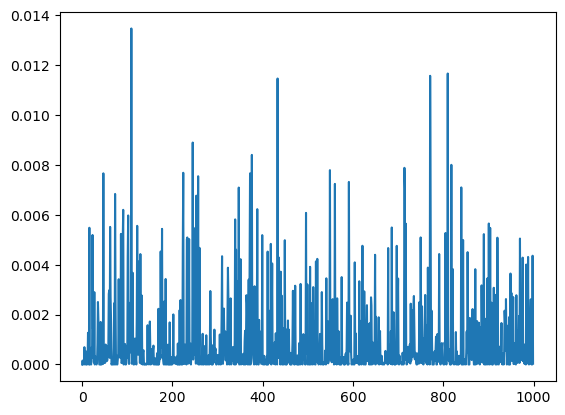

In [ ]:
import matplotlib.pyplot as plt
plt.plot(out.weights[1])

In [ ]:
X

,0,1,2,3,4,5,6,7,8,9
0,-0.266003,-2.326927,-0.167144,0.453611,0.812868,-1.006852,-0.641708,0.731970,-0.588226,-1.455783
1,-0.751619,0.264833,1.360680,-0.362382,0.138664,-1.288945,1.163419,-1.434050,2.383210,0.829570
2,0.817424,1.356615,-0.552565,-1.355037,1.316007,0.081166,0.918712,1.113968,0.981624,-2.022905
3,-0.250678,-0.086365,-1.141409,0.497923,-0.013811,-0.207577,0.046045,0.436048,-0.783918,-1.346805
4,-0.774400,0.788283,-0.949928,-0.411523,-0.582428,0.793978,0.703432,0.262494,-1.692180,0.417725
...,...,...,...,...,...,...,...,...,...,...
995,1.559576,-0.306926,-0.381987,-1.133386,-0.413252,0.162760,0.327102,-0.810778,-0.614363,-1.354231
996,-1.213105,-1.096146,0.742233,0.941367,-0.054013,0.305591,-0.704571,-0.151366,-1.890847,-0.507476
997,-1.445236,0.902850,0.298827,1.549959,-0.923840,-1.026148,-1.958187,0.818318,-0.223226,-1.724601
998,0.253199,-1.608266,-0.806056,0.681402,-1.294518,2.019172,0.839666,0.165261,-0.255498,-0.301274


In [ ]:
Y

,0,1
0,-0.912819,-2.529923
1,-0.999677,-0.200527
2,0.717756,-0.162220
3,-1.885987,-0.082575
4,-1.494624,-0.539509
...,...,...
995,2.020581,0.128688
996,-1.513625,0.063839
997,-2.208074,-0.002965
998,0.646438,0.023884
